In [ ]:
!pip install medpy
!pip install segmentation-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=36de0ef0591767efab54f1f726be7da85f7bb2cbc0437187a4739f388d12b7cc
  Stored in directory: /root/.cache/pip/wheels/dc/af/c6/29c32d7a52dc21d75b93ac8d2f54644718512ccb2b363d981b
Successfully built medpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cu

In [ ]:
import os
import numpy as np
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Cursor
import skimage.io as io
from math import ceil
import glob
import tensorflow as tf
import keras
from keras.models import load_model
import shutil
import keras.backend as K

In [ ]:
trainPath = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [ ]:
# dice loss as defined above for 4 classes
# The smooth parameter is added to avoid division by zero error and to stabilize the loss calculation.
# def dice_coef(y_true, y_pred, smooth=1):
#     class_num = 4
#     for i in range(class_num):
#         y_true_f = K.flatten(y_true[:,:,:,i])
#         y_pred_f = K.flatten(y_pred[:,:,:,i])
#         intersection = K.sum(y_true_f * y_pred_f)
#         loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
#         if i == 0:
#             total_loss = loss
#         else:
#             total_loss = total_loss + loss
#     total_loss = total_loss / class_num
#     return total_loss

def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef

def dice_coef_necrotic(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=0.000001):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
# Precision: TP / (TP + FP)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

    
# Computing Sensitivity  
# Sensitivity or recall: TP / (TP + FN)
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
# Specificity: TN / (TN + FP)
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def load(filepath):
    file_ext = filepath.split('.')[-1]
    name = filepath.split('.')[-2].split('/')[-1]
    
    # Load inputs data
    if file_ext == 'mha':
        image_data, image_header = medpy.io.load(filepath)
    elif file_ext == 'nii' or 'nii' + file_ext == 'niigz':
        image_data = nib.load(filepath).get_fdata()
    elif file_ext == 'npy':
        image_data = np.load("filename")
    else:
        print("Make sure to enter a supported file extension (.mha / .nii / .nii.gz / .npy)")
        return -1

    print("File information:")
    print("\t Input file name: {}".format(name))
    print("\t Input file type: {}".format(file_ext))
    print("\t Shape: {}".format(image_data.shape))

    print("----------------------------------------------------------------")
    return np.array(image_data)

In [ ]:
def display2D(brain_data, seg_data=None, brain_color_map='bone', seg_color_map='jet'):

	if len(brain_data) < 0:
		# Return value of loadign image < -1 -> error occurred
		return -1
	if brain_data.ndim != 3:
		print("You should provide a 3 dimension array as brain data")
		return -1

	print("Type of brain data {}".format(type(brain_data)))

	if seg_data is not None:
		if len(seg_data) < 0:
			return -1
		if seg_data.ndim != 3:
			print("You should provide a 3 dimension array as seg data")
			return -1
		if brain_data.shape != seg_data.shape:
			print("Image data and Segmentation data do not have the same shape {}!={}".format(brain_data.shape, seg_data.shape))
			return -1

	print("Type of seg data {}".format(type(seg_data)))
	print("Brain and Segmentation data have shape {}".format(brain_data.shape))
        
	fig, ax = plt.subplots(1, 2)
        
    
	cut = random.randint(0, 2)

	if cut == 0:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("YZ cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[index, :, :], cmap=brain_color_map)
			ax[1].imshow(seg_data[index, :, :], cmap=seg_color_map)
		else:
			plt.title("YZ cut | layer: {}".format(index))
			plt.imshow(brain_data[index, :, :], cmap=brain_color_map)

	elif cut == 1:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("XZ cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[:, index, :], cmap=brain_color_map)
			ax[1].imshow(seg_data[:, index, :], cmap=seg_color_map)
		else:
			plt.title("XZ cut | layer: {}".format(index))
			plt.imshow(brain_data[:, index, :], cmap=brain_color_map)

	elif cut == 2:
		index = random.randint(0, brain_data.shape[cut]-1)
		if seg_data is not None:
			ax[0].set_title("XY cut | layer: {}".format(index))
			ax[1].set_title("Segmentation/Mask")
			ax[0].imshow(brain_data[:, :, index], cmap=brain_color_map)
			ax[1].imshow(seg_data[:, :, index], cmap=seg_color_map)
		else:
			plt.title("XY cut | layer: {}".format(index))
			plt.imshow(brain_data[:, :, index], cmap=brain_color_map)

File information:
	 Input file name: BraTS20_Training_001_t1ce
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
File information:
	 Input file name: BraTS20_Training_001_seg
	 Input file type: nii
	 Shape: (240, 240, 155)
----------------------------------------------------------------
Type of brain data <class 'numpy.ndarray'>
Type of seg data <class 'numpy.ndarray'>
Brain and Segmentation data have shape (240, 240, 155)


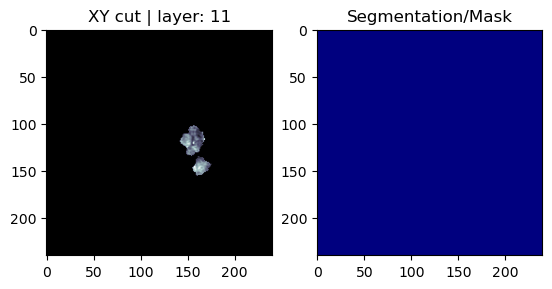

In [ ]:
PATIENT = "001"
SEQUENCE = "t1ce"
image_path = trainPath + "BraTS20_Training_{}/BraTS20_Training_{}_{}.nii".format(PATIENT, PATIENT, SEQUENCE)
seg_path = trainPath + "BraTS20_Training_{}/BraTS20_Training_{}_seg.nii".format(PATIENT, PATIENT)
image_data = load(image_path)
seg_data = load(seg_path)
display2D(image_data, seg_data)

In [ ]:
def display3DCuts(brain_data, seg_data=None, brain_color_map='bone', seg_color_map='jet', seg_alpha=0.5):

	if len(brain_data) < 0:
		print("Brain data is empty")
		return -1
	if brain_data.ndim != 3:
		print("You should provide a 3 dimension array as brain data")
		return -1

	print("Type of brain data {}".format(type(brain_data)))

	if seg_data is not None:
		if len(seg_data) < 0:
			print("Segmentation data is empty")
			return -1
		if seg_data.ndim != 3:
			print("You should provide a 3 dimension array as seg data")
		if brain_data.shape != seg_data.shape:
			print("Image data and Segmentation data do not have the same shape {}!={}".format(brain_data.shape, seg_data.shape))
			return -1

	print("Type of seg data {}".format(type(seg_data)))
	print("Brain and Segmentation data have shape {}".format(brain_data.shape))

	# Plot with 3 Columns
	fig, ax = plt.subplots(1, 3)
	plt.subplots_adjust(bottom=0.25)

	# Create layers to place widgets
	axlayer_X = plt.axes([0.25, 0.2, 0.30, 0.03])
	axlayer_Y = plt.axes([0.25, 0.15, 0.30, 0.03])
	axlayer_Z = plt.axes([0.25, 0.1, 0.30, 0.03])

	# Get aprox the middle images for each of X Y Z
	half_X = ceil((brain_data.shape[0] - 1)/2)
	half_Y = ceil((brain_data.shape[1] - 1)/2)
	half_Z = ceil((brain_data.shape[2] - 1)/2)

	# Create Slider for each cut
	slider_X = Slider(axlayer_X, "Sagittal Cut", 0, brain_data.shape[0] - 1, valinit=half_X, valstep=1)
	slider_Y = Slider(axlayer_Y, "Coronal Cut", 0, brain_data.shape[1] - 1, valinit=half_Y, valstep=1)
	slider_Z = Slider(axlayer_Z, "Horizontal Cut", 0, brain_data.shape[2] - 1, valinit=half_Z, valstep=1)

	# Set title for each ax
	ax[0].set_title("{}/{}".format(half_X, brain_data.shape[0] - 1))
	ax[1].set_title("{}/{}".format(half_Y, brain_data.shape[1] - 1))
	ax[2].set_title("{}/{}".format(half_Z, brain_data.shape[2] - 1))

	# Update function for each respective slider and it's plot
	def update_X(val):
		layer = slider_X.val
		ax[0].imshow(brain_data[layer,:,:], cmap=brain_color_map)
		if seg_data is not None:
			ax[0].imshow(seg_data[layer,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[layer,:,:]>0))
		ax[0].set_title("{}/{}".format(layer, brain_data.shape[0] - 1))
		fig.canvas.draw_idle()

	def update_Y(val):
		layer = slider_Y.val
		ax[1].imshow(brain_data[:,layer,:], cmap=brain_color_map)
		if seg_data is not None:
			ax[1].imshow(seg_data[:,layer,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,layer,:]>0))
		ax[1].set_title("{}/{}".format(layer, brain_data.shape[1] - 1))
		fig.canvas.draw_idle()

	def update_Z(val):
		layer = slider_Z.val
		ax[2].imshow(brain_data[:,:,layer], cmap=brain_color_map)
		if seg_data is not None:
			ax[2].imshow(seg_data[:,:,layer], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,layer]>0))
		ax[2].set_title("{}/{}".format(layer, brain_data.shape[2] - 1))
		fig.canvas.draw_idle()


	# Update plot when interaction detected on slider
	slider_X.on_changed(update_X)
	slider_Y.on_changed(update_Y)
	slider_Z.on_changed(update_Z)
	

	# First display
	ax[0].imshow(brain_data[half_X,:,:], cmap=brain_color_map)
	ax[1].imshow(brain_data[:,half_Y,:], cmap=brain_color_map)
	ax[2].imshow(brain_data[:,:,half_Z], cmap=brain_color_map)
	if seg_data is not None:
		ax[0].imshow(seg_data[half_X,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[half_X,:,:]>0), vmin = 0)
		ax[1].imshow(seg_data[:,half_Y,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,half_Y,:]>0), vmin = 0)
		ax[2].imshow(seg_data[:,:,half_Z], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,half_Z]>0), vmin = 0)


	# Turn off all of the axis
	ax[0].axis('off')
	ax[1].axis('off')
	ax[2].axis('off')

	# Show plot
	plt.show()

Type of brain data <class 'numpy.ndarray'>
Type of seg data <class 'numpy.ndarray'>
Brain and Segmentation data have shape (240, 240, 155)


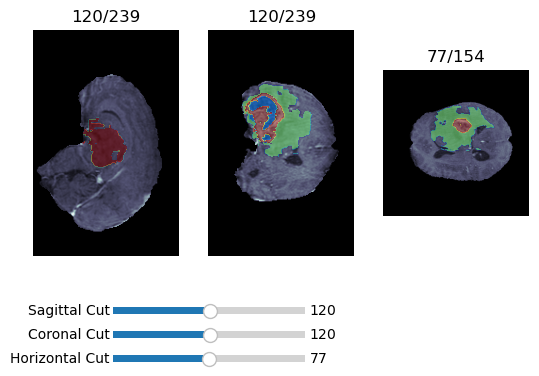

In [ ]:
display3DCuts(image_data, seg_data) # Due to colab not being interactive with matplotlib interactive ploting not working for the moment

In [ ]:
# def process_images(patient_dir_path, processed_dir_path="", file_ext='nii'):

# 	patient = patient_dir_path.split('/')[-1]

# 	image_flair = load(os.path.join(patient_dir_path, "{}_flair.{}".format(patient, file_ext)))
# 	image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

# 	"""
# 	# Not useful
# 	test_image_t1 = load(os.path.join(patient_dir_path, "{}_t1.{}".format(patient, file_ext)))
# 	test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
# 	"""

# 	image_t1ce = load(os.path.join(patient_dir_path, "{}_t1ce.{}".format(patient, file_ext)))
# 	image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

# 	image_t2 = load(os.path.join(patient_dir_path, "{}_t2.{}".format(patient, file_ext)))
# 	image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

# 	if image_flair.shape == image_t1ce.shape == image_t2.shape and image_flair.ndim == image_t1ce.ndim == image_t2.ndim == 3 :
# 		# Stack 3 most important channel into 1 numpy array to feed the U-Net
# 		resulting_image = np.stack([image_flair,
# 									image_t1ce,
# 									image_t2], axis=3)

# 		# Crop the image from 240x240x155 to 128x128x128
# 		resulting_image = resulting_image[56:184, 56:184, 13:141] # Shape 128x128x128x3 (x4 if t1 included)

# 		np.save(os.path.join(processed_dir_path, "images", patient+".npy"), resulting_image)
		
# 	else:
# 		print("Channels don't have the same shape and/or are not conform to the standard IRM dim (X, X, X) for each channel")
# 		return -1
     

In [ ]:

# def process_mask(patient_dir_path, processed_dir_path="", file_ext='nii'):

# 	patient = patient_dir_path.split('/')[-1]

# 	mask = load(os.path.join(patient_dir_path, "{}_seg.{}".format(patient, file_ext)))
# 	mask = mask.astype(np.uint8)

# 	mask[mask==4] = 3 
# 	mask = mask[56:184, 56:184, 13:141] # Shape 128x128x128

# 	mask = to_categorical(mask, num_classes=4)
# 	np.save(os.path.join(processed_dir_path, "mask", patient+".npy"), mask)



In [ ]:
# def process_patient(patient_dir_path, processed_path="", val=False):
#     """
#     Processes the images and the mask of a single patient by calling above functions
#     """
#     if val:
#         process_mask(patient_dir_path, processed_path)
#         process_images(patient_dir_path, processed_path)
#         return True
#     else:
#         if random.randint(0,10) <= 8: # Get a ~80% chance of getting picked for training
#             process_mask(patient_dir_path, processed_path)
#             process_images(patient_dir_path, processed_path)
#             return True
#         return False

In [ ]:
# def process_dataset(dataset_path=None, processed_path="", val=False):
#     """
#     Process an entire dataset with a specific schema
#     """
    
#     if dataset_path is None:
#         print("Please enter a dataset path")
#         return -1

#     # Create the folders in which fill the processed images following schema:
#     """ training_processed/
#     ├─ images/
#     │  ├─ BraTS20_Training_001.npy
#     │  ├─ BraTS20_Training_002.npy
#     │  ├─ BraTS20_Training_XXX.npy
#     │  ├─ BraTS20_Training_YYY.npy
#     ├─ mask/
#     │  ├─ BraTS20_Training_001.npy
#     │  ├─ BraTS20_Training_002.npy
#     │  ├─ BraTS20_Training_XXX.npy
#     │  ├─ BraTS20_Training_YYY.npy
#     """
#     #os.mkdir(processed_path)
#     os.mkdir(processed_path+"/images")
#     os.mkdir(processed_path+"/mask")

#     # Processes each patient in the original dataset
#     for dirname, patients, filenames in os.walk(dataset_path):
#         for patient in patients: 
#             if process_patient(os.path.join(dirname, patient), processed_path, val):
#                 # uncomment the line below if you want to delete the raw data after processing it (convinient for online limitied storage)
#                 #shutil.rmtree(os.path.join(dirname, patient))
#                 pass
     

In [ ]:
# if not os.path.exists("/kaggle/working/BraTS2020_ProcessedData/"):
#     os.mkdir("/kaggle/working/BraTS2020_ProcessedData/")
# if not os.path.exists("/kaggle/working/BraTS2020_ProcessedData/train"):
#     os.mkdir("/kaggle/working/BraTS2020_ProcessedData/train")
# if not os.path.exists("/kaggle/working/BraTS2020_ProcessedData/val"):
#     os.mkdir("/kaggle/working/BraTS2020_ProcessedData/val")


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' # the way we initialize our weights


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.summary()
    
    return model

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# Init a MinMaxScaler
scaler = MinMaxScaler()

def loadImageBis(folders, image_list):
    """
    Load images in a given directory for a given list
    """

    X_images = []
    Y_images = []

    
    data = np.zeros((240,240,155,3))
    
    
        
    for i, image_name in enumerate(image_list):
        
        image_flair, image_t1ce, image_t2 = None, None, None
        
        folder_path = path + '/' + image_name;
        modalities = os.listdir(folder_path)
        modalities.sort()

        w = 0
        for j in range(len(modalities)):
          image_path = folder_path + '/' + modalities[j]
          if(image_path[-7:-1] + image_path[-1] == 'seg.nii'):
#                 print(image_path)
                img = nib.load(image_path);
                mask = img.get_fdata()
#                 image_data2 = np.asarray(image_data2)
                mask = mask.astype(np.uint8)
                mask[mask==4] = 3 
                mask = mask[56:184, 56:184, 13:141] # Shape 128x128x128
                mask = to_categorical(mask, num_classes=4)
                Y_images.append(mask)

          else:
                if(image_path[-7:-1] + image_path[-1] == '1ce.nii'):                    
                    img = nib.load(image_path);
#                     print(image_path)
                    image_t1ce = img.get_fdata()
                if(image_path[-7:-1] + image_path[-1] == 'air.nii'):   
#                     print(image_path)
                    img = nib.load(image_path);
                    image_flair = img.get_fdata()
                if(image_path[-7:-1] + image_path[-1] == '_t2.nii'):  
#                     print(image_path)
                    img = nib.load(image_path);
                    image_t2 = img.get_fdata()
        
        if (image_flair is None or image_t1ce is None or image_t2 is None):
            print("None has encountered "+folder_path)
         
        image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)          
        image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)
        image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)
        
        resulting_image = np.stack([image_flair, image_t1ce,image_t2], axis=3)

        # Crop the image from 240x240x155 to 128x128x128
        resulting_image = resulting_image[56:184, 56:184, 13:141]
        X_images.append(resulting_image)        
    
    X_images = np.array(X_images)
    Y_images = np.array(Y_images)
    
    return X_images, Y_images



In [ ]:
def imageLoader(image_dir, image_list, batch_size):
    
    L = len(image_list)

    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)


            X, Y = loadImageBis(image_dir, image_list[batch_start:limit])
#             Y = loadImageBis(mask_dir, mask_list[batch_start:limit])

            yield(X, Y)

            batch_start += batch_size
            batch_end += batch_size
     

In [ ]:
from sklearn.model_selection import train_test_split

all_images = os.listdir(path)
all_images.sort()
print(len(all_images))
print(all_images[-5:])
all_images.remove('name_mapping.csv')
all_images.remove('survival_info.csv')

print(os.listdir(path+'BraTS20_Training_355'))
all_images.remove('BraTS20_Training_355')
print(all_images[-5:])

print(len(all_images))

371
['BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369', 'name_mapping.csv', 'survival_info.csv']
['BraTS20_Training_355_flair.nii', 'W39_1998.09.19_Segm.nii', 'BraTS20_Training_355_t2.nii', 'BraTS20_Training_355_t1.nii', 'BraTS20_Training_355_t1ce.nii']
['BraTS20_Training_365', 'BraTS20_Training_366', 'BraTS20_Training_367', 'BraTS20_Training_368', 'BraTS20_Training_369']
368


In [ ]:
train_folders, test_val_folders  = train_test_split(all_images, test_size=0.25, random_state=42)

val_folders, test_folders = train_test_split(test_val_folders, test_size=0.5, random_state=42)

# print the results
print('Test_Val Folders:', len(test_val_folders))
print('Train Folders:', len(train_folders))
print('Test Folders:', len(test_folders))
print('Val Folders:', len(val_folders))

Test_Val Folders: 92
Train Folders: 276
Test Folders: 46
Val Folders: 46


In [ ]:
# train_img_dir = "/content/BraTS2020_ProcessedData/train/images/"
# train_mask_dir = "/content/BraTS2020_ProcessedData/train/mask/"

# val_img_dir = "/content/BraTS2020_ProcessedData/val/images/"
# val_mask_dir = "/content/BraTS2020_ProcessedData/val/mask/"

# train_img_list=os.listdir(train_img_dir)
# train_mask_list = os.listdir(train_mask_dir)

# val_img_list=os.listdir(val_img_dir)
# val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

# train_img_datagen = imageLoader(train_img_dir, train_img_list, 
#                                 train_mask_dir, train_mask_list, batch_size)

# val_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)


train_img_datagen = imageLoader(path, train_folders, batch_size)
val_img_datagen = imageLoader(path, val_folders, batch_size)
test_img_datagen = imageLoader(path, test_folders, batch_size)

        
# training_generator = DataGenerator(train_folders)
# valid_generator = DataGenerator(val_folders)
# test_generator = DataGenerator(test_folders)



#Verify generator.... In python 3 next() is renamed as __next__()


In [ ]:
# for i in range(len(val_folders)):
#     img, msk = val_img_datagen.__next__()
#     print(i,img[0].shape, img[1].shape)


In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


metrics = ['accuracy', sm.metrics.FScore(), sm.metrics.IOUScore(threshold=0.5), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing ]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

steps_per_epoch = len(train_folders)//batch_size
val_steps_per_epoch = len(val_folders)//batch_size


# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= "/kaggle/working/brats_3d_simple_unet_{epoch:02d}.h5",
#                                                  save_weights_only=False,
#                                                  verbose=1)

# tb_callback = tf.keras.callbacks.TensorBoard('logs')

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics) # Adding metrics to replace accuracy (Wrong interpretation)

print(model.input_shape)
print(model.output_shape)


Segmentation Models: using `tf.keras` framework.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)       

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save model checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath='my_model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=20, 
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks=[checkpoint_callback]
          )

Epoch 1/5
138/138 [==============================] - 513s 4s/step - loss: 0.9579 - accuracy: 0.8545 - f1-score: 0.2361 - iou_score: 0.1875 - dice_coef: 0.2989 - precision: 0.8567 - sensitivity: 0.7386 - specificity: 0.9857 - dice_coef_necrotic: 0.8471 - dice_coef_edema: 0.8674 - dice_coef_enhancing: 0.8669 - val_loss: 0.9444 - val_accuracy: 0.9488 - val_f1-score: 0.2628 - val_iou_score: 0.1981 - val_dice_coef: 0.3632 - val_precision: 0.9882 - val_sensitivity: 0.7660 - val_specificity: 0.9968 - val_dice_coef_necrotic: 0.9957 - val_dice_coef_edema: 0.9978 - val_dice_coef_enhancing: 0.9982
Epoch 2/5
138/138 [==============================] - 475s 3s/step - loss: 0.9297 - accuracy: 0.9482 - f1-score: 0.3166 - iou_score: 0.2426 - dice_coef: 0.3985 - precision: 0.9744 - sensitivity: 0.9051 - specificity: 0.9919 - dice_coef_necrotic: 0.9992 - dice_coef_edema: 0.9998 - dice_coef_enhancing: 0.9998 - val_loss: 0.9295 - val_accuracy: 0.8989 - val_f1-score: 0.3205 - val_iou_score: 0.2631 - val_dic

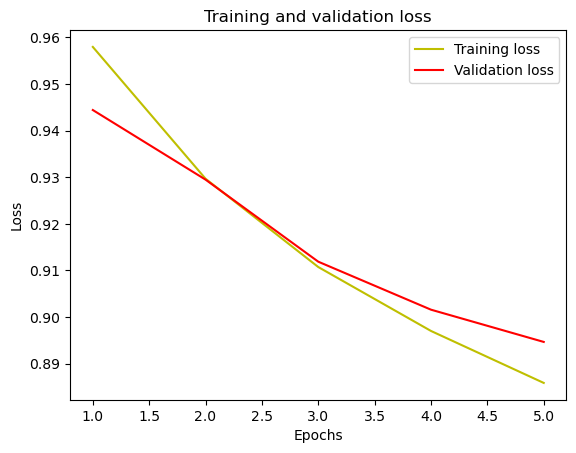

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

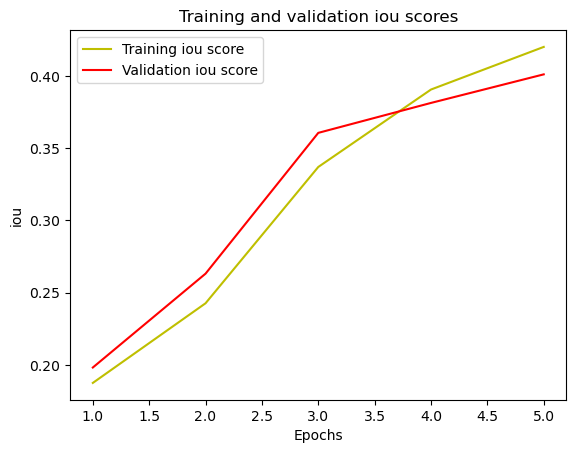

In [ ]:
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

plt.plot(epochs, iou, 'y', label='Training iou score')
plt.plot(epochs, val_iou, 'r', label='Validation iou score')
plt.title('Training and validation iou scores')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

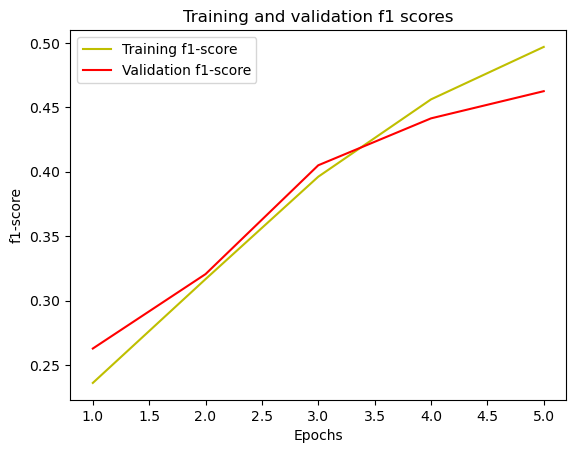

In [ ]:
f_score = history.history['f1-score']
val_f_score = history.history['val_f1-score']

plt.plot(epochs, f_score, 'y', label='Training f1-score')
plt.plot(epochs, val_f_score, 'r', label='Validation f1-score')
plt.title('Training and validation f1 scores')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [ ]:
# img_num = "001"

# test_img = np.load(path+ "BraTS20_Training_"+str(img_num))

# loadImageBis(test_, image_list)

# test_mask = np.load("/content/BraTS2020_ProcessedData/val/mask/BraTS20_Training_"+str(img_num)+".npy")
# test_mask_argmax=np.argmax(test_mask, axis=3)

# test_img_input = np.expand_dims(test_img, axis=0)

# my_model = load_model('/content/saved_models/brats_3d_simple_unet_50.h5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5),
#                                       'f1-score':sm.metrics.FScore()})
test_img_datagen = imageLoader(path, test_folders, batch_size)

In [ ]:
imgList, maskList = test_img_datagen.__next__()

In [ ]:
def testPrediction(imgList, maskList):
    
    for i in range(2):

        img = imgList[i]
        mask = maskList[i]

        test_img_input = np.expand_dims(img, axis=0)
        test_mask_argmax=np.argmax(mask, axis=3)

        test_prediction = model.predict(test_img_input)
        test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


        #n_slice=random.randint(0, test_prediction_argmax.shape[2])
        n_slice = 50
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title('Image')
        plt.imshow(img0[:,:,n_slice,1], cmap='bone')
        plt.subplot(232)
        plt.title('Ground truth')
        plt.imshow(test_mask_argmax[:,:,n_slice], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction')
        plt.imshow(test_prediction_argmax[:,:, n_slice], cmap='jet')
        plt.show()

1/1 [==============================] - 0s 54ms/step


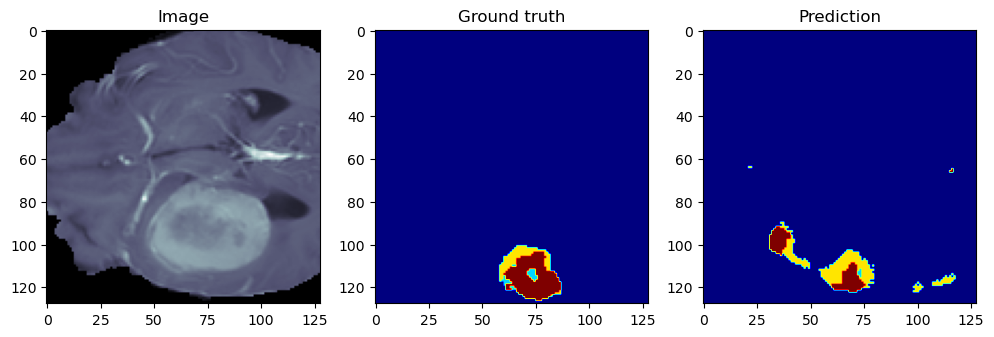

1/1 [==============================] - 0s 46ms/step


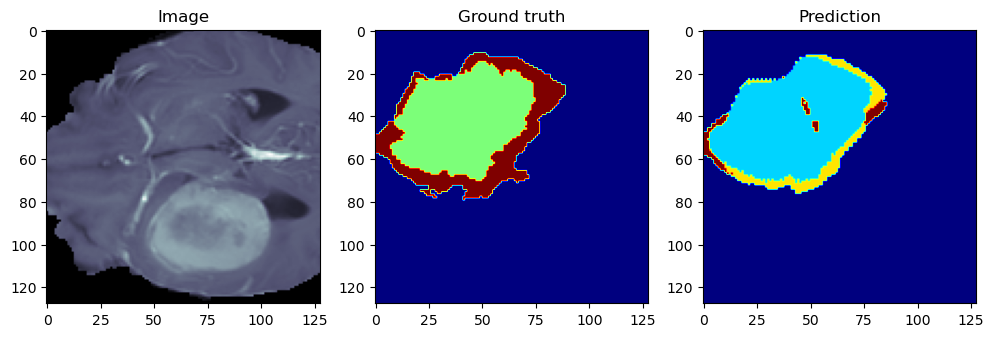

In [ ]:
imgList, maskList = test_img_datagen.__next__()
testPrediction(imgList, maskList)

1/1 [==============================] - 0s 44ms/step


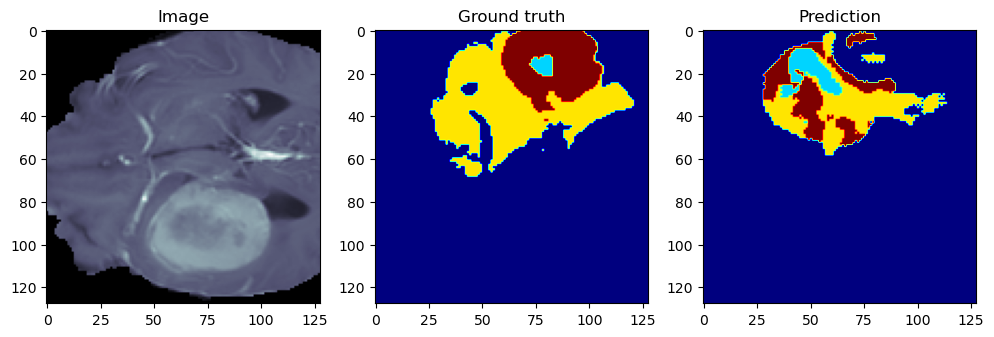

1/1 [==============================] - 0s 43ms/step


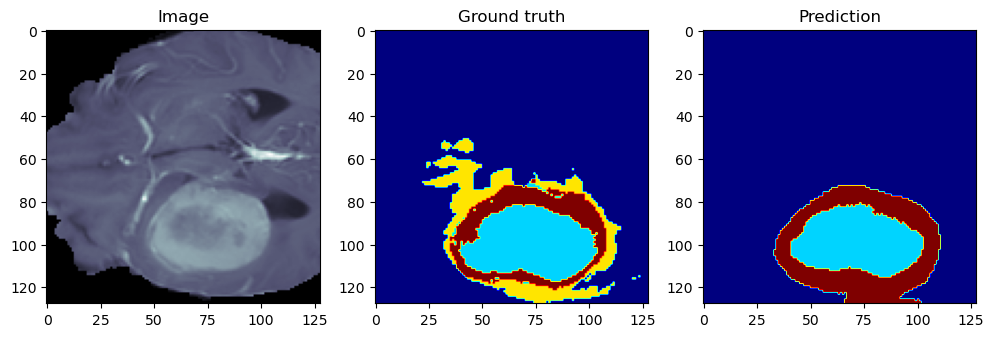

In [ ]:
imgList, maskList = test_img_datagen.__next__()
testPrediction(imgList, maskList)

1/1 [==============================] - 0s 72ms/step


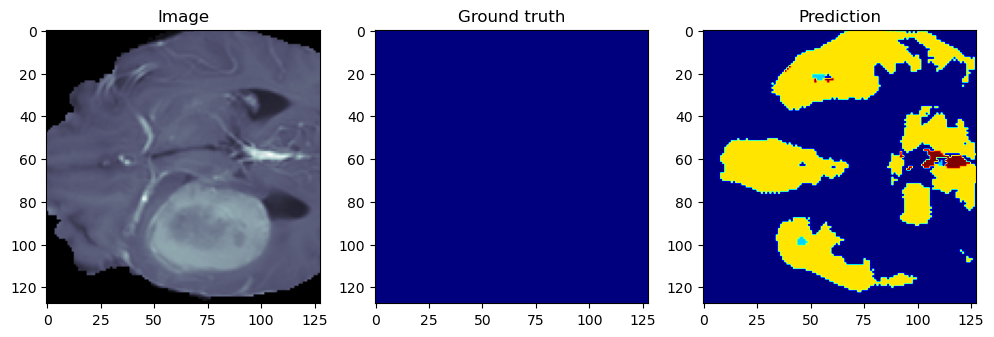

1/1 [==============================] - 0s 51ms/step


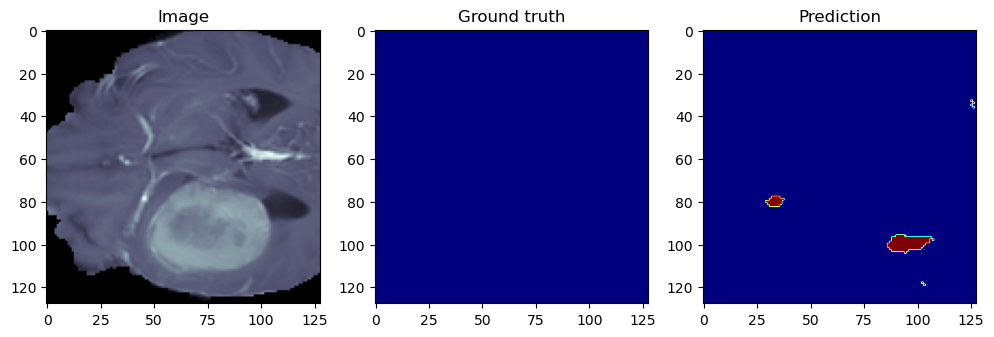

In [ ]:
imgList, maskList = test_img_datagen.__next__()
testPrediction(imgList, maskList)

1/1 [==============================] - 0s 47ms/step


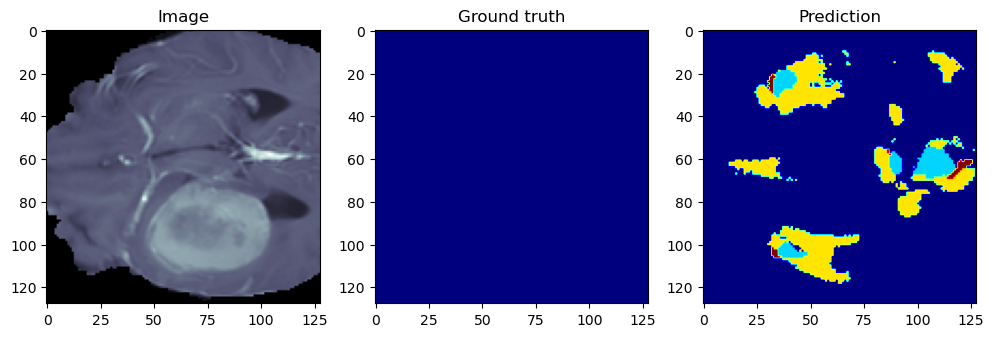

1/1 [==============================] - 0s 36ms/step


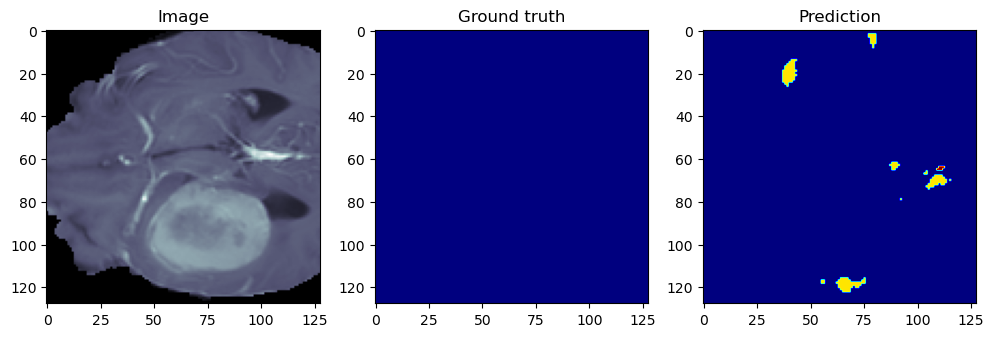

In [ ]:
imgList, maskList = test_img_datagen.__next__()
testPrediction(imgList, maskList)